In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy pandas numpy_ringbuffer sklearn

import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from strategy import Strategy
from sklearn.decomposition import PCA

In [3]:
currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

In [4]:
def find_gaps(data, freq):
    # creating reference DatetimeIndex
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)

    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

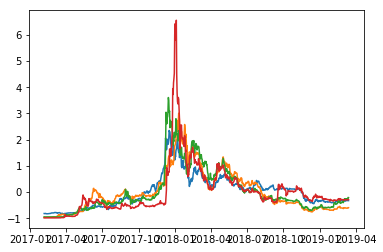

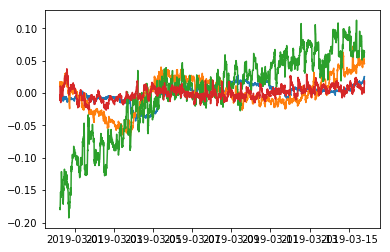

False


In [26]:
def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return { 'prices': pd.DataFrame(prices, index = dates), 'volumes': pd.DataFrame(volumes, index = dates)}

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).mean().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def data_currencies(data):
    currencies = ['usd']
    for pair in data['prices'].columns:
        currencies.append(pair.partition('_')[0])
    return currencies

data = prep_data('data.p')
viz_data(data)
data_min = prep_data('data-minute.p')
data_5min = reduce_data(data_min, '5Min')
data_15min = reduce_data(data_min, '15Min')
viz_data(data_5min)

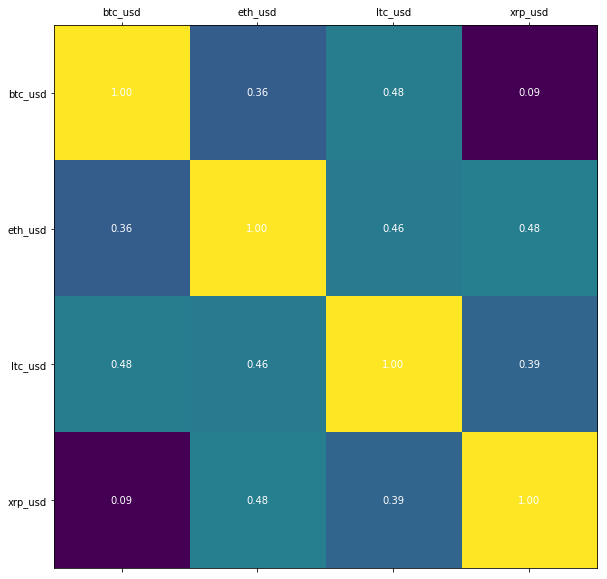

In [7]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df['prices'].corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    # Loop over data dimensions and create text annotations.
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, '{:0.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="w")

plot_corr(data_15min)

In [27]:
def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        # hacky...
        currency = pair.partition("_")[0]
        balances['usd'] -= size * prices[pair]
        balances[currency] += size

def pnl(balances, prices):
    usd = 0
    for (currency, qty) in balances.items():
        if currency == 'usd':
            usd += qty
        else:
            pair = currency + '_usd'
            usd += qty * prices[pair]
    return usd


def market_risk(diff_stddevs, pcs, balances):
    '''sqrt(sum(position * var(currency) * pc1[currency]))'''
    balances = pd.DataFrame([{(k+'_usd'):v for k,v in balances.items() if k != 'usd'}])
    risk = np.abs(pcs.values.dot((balances * diff_stddevs).values.T))
    return np.linalg.norm(risk) + 1 # avoid div by 0

def evaluate(strategy, data, fees = 0):
    '''data is prices per-day
    TODO: separate hedger from strategy?'''
    balances = dict.fromkeys(data_currencies(data), 0)
    dates = []
    pnls = []
    balances_ = []
    balance_values = []
    risks = []
    price_diffs = data['prices'].diff().iloc[1:]
    diff_stddevs = price_diffs.std()
    diff_pca = PCA(n_components=0.997)
    diff_pca.fit(price_diffs)
    pcs = pd.DataFrame(diff_pca.components_, columns = data['prices'].columns)
    for (date, prices) in data['prices'].iterrows():
        volumes = data['volumes'].loc[date]
        orders = strategy.step(balances, prices, volumes)
        execute_orders(fees, prices, balances, orders)
        current_pnl = pnl(balances, prices)
        def price(currency):
            if currency == 'usd':
                return 1
            return prices[currency + '_usd']
        dates.append(date)
        balances_.append(balances.copy())
        balance_values.append({ c: qty * price(c) for c, qty in balances.items() })
        pnls.append(current_pnl)
        risks.append(market_risk(diff_stddevs, pcs, balances))
    return {
        'P/L': pd.DataFrame(pnls, index=dates, columns=["P/L"]),
        'balances': pd.DataFrame(balances_, index=dates),
        'balance_values': pd.DataFrame(balance_values, index=dates),
        'risks': pd.DataFrame(risks, index=dates, columns=["Market Risk"])
    }

def return_on_risk(results):
    return results['P/L'].iloc[-1, 0] / results['risks'].values.sum()

def plot_results(results):
    '''Plots balances (with P/L) and market risk over time for the given strategy results.
    
    Note: RoRs are per-tick. They are NOT comparable across time scales.'''
    fig, axs = plt.subplots(1,2, figsize=(16, 4))
    results['balance_values'].plot(ax=axs[0])
    results['P/L'].plot(ax=axs[0])
    results['risks'].plot(ax=axs[1])
    axs[1].axhline(0, color='grey')
    plt.show()
    print('Final RoR: {0}'.format(return_on_risk(results)))
    print('Final P/L: {0}'.format(results['P/L'].iloc[-1, 0]))
    print('Final balances:')
    print(results['balances'].iloc[-1])

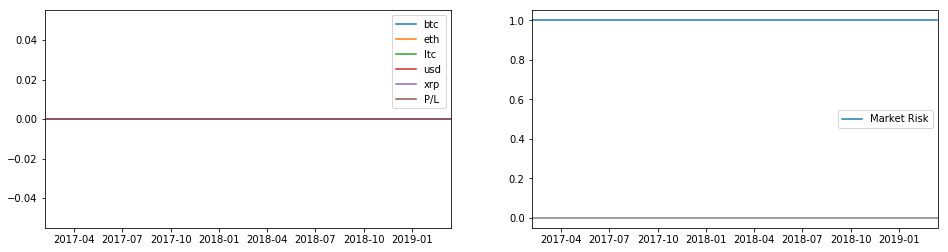

Final RoR: 0.0
Final P/L: 0.0
Final balances:
btc    0
eth    0
ltc    0
usd    0
xrp    0
Name: 2019-03-14, dtype: int64


In [28]:
from strategy import HoldStrategy

plot_results(evaluate(HoldStrategy(), data))

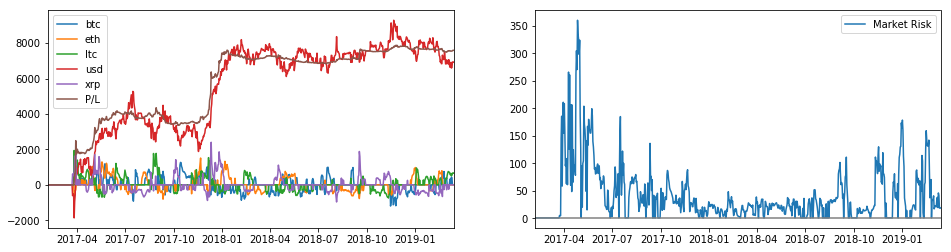

Final RoR: 0.2379474717406314
Final P/L: 7592.4833610258975
Final balances:
btc       0.000000
eth       0.000000
ltc      10.841830
usd    6928.095998
xrp       0.000000
Name: 2019-03-14, dtype: float64


In [29]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer
from math import log1p

class StatArb(Strategy):
    def __init__(self, correlation_window_size, movement_half_life, size, min_edge = 0, max_edge = 1e100, correlation_subsampling = 1):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge
        '''
        self.moving_prices_history = None 
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.correlation_subsampling = correlation_subsampling
        self.moving_prices = MovingAverage(movement_half_life)
        
    def desired_balance_value(self, edge):
        '''Returns (expressed in USD) the desired balance for a currency at the given edge from fair'''
        if abs(edge) < self.min_edge:
            return 0
        if abs(edge) >= self.max_edge:
            return 0
        return edge * self.size
        
    def step(self, balances, prices, volumes):
        '''Weighting predictions by volume or market cap data doesn't seem to improve RoR. My guess is that because
        doing so breaks the symmetry in order sizing, the strategy becomes no longer well-hedged.'''
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        self.moving_prices.step(prices)
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return {}
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        
#         # subsampling
#         df = df.groupby(np.arange(len(df)) // self.correlation_subsampling).mean()
        
        # Calculates fair movements by averaging correlated movements between all pairs, weighted by r^2
        # Concretely:
        # fair_btc_movement =
        #   (btc_movment
        #    + eth_movement * r_eth^3 * stddev_btc/stddev_eth
        #    + ltc_movement * r_ltc^3 * stddev_btc/stddev_ltc
        #    + xrp_movement * r_xrp^3 * stddev_btc/stddev_xrp)
        #   / (1 + r_eth^2 + r_ltc^2 + r_xrp^2)
        
        # compute fairs, edges
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_deltas = (deltas * corr).mul(stddevs, axis=0).div(stddevs, axis=1)
        confidences = corr ** 2
        fair_deltas = (predicted_deltas * confidences).sum(axis=1) / confidences.sum(axis=1)
        edges = (deltas - fair_deltas) / stddevs
        
        # turn fairs into orders
        orders = {}
        for (pair, edge) in edges.items():
            currency = pair.partition('_')[0]
            orders[pair] = self.desired_balance_value(edges[pair]) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(StatArb(correlation_window_size = 48, movement_half_life = .01, size = 1000, min_edge = 0.25), data))

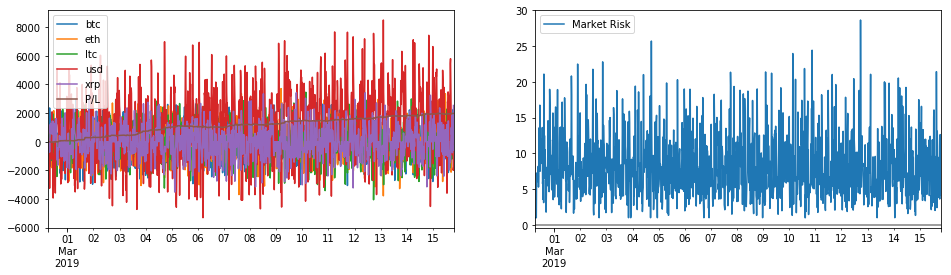

Final RoR: 0.16356260221731542
Final P/L: 1976.068943645417
Final balances:
btc       0.488861
eth      -4.584334
ltc       0.000000
usd   -1837.562761
xrp    8002.314895
Name: 2019-03-15 19:00:00, dtype: float64


In [34]:
plot_results(evaluate(StatArb(correlation_window_size = 8, movement_half_life = 2, size = 1000, min_edge = 0.25), data_15min))

In [ ]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1)
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.uniform(3, 10))
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        results = evaluate(StatArb(window_size, movement_half_life, size=1000, min_edge=0.25), data)
        ror = return_on_risk(results)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(data_15min, 25)

Trying window_size: 8 and half_life: 0.5255819622751667
  RoR: 0.1416714242220323
Trying window_size: 6 and half_life: 0.8183076898646381
  RoR: 0.16878531060991434
Trying window_size: 6 and half_life: 2.2078352815091935
  RoR: 0.18508513672370178
Trying window_size: 4 and half_life: 0.29512193706525336
  RoR: 0.11997287379238918
Trying window_size: 5 and half_life: 0.14932498246332146
  RoR: 0.12178570530060444
Trying window_size: 5 and half_life: 0.08945231828051378
  RoR: 0.12039139696188197
Trying window_size: 5 and half_life: 0.09055592772776337
  RoR: 0.12184032352301308
Trying window_size: 4 and half_life: 0.4591412930175788
  RoR: 0.14952140860321952
Trying window_size: 6 and half_life: 0.25822180798693023
  RoR: 0.11932985929041458
Trying window_size: 4 and half_life: 0.0685562979869608
  RoR: 0.07878764620619697
Trying window_size: 3 and half_life: 0.2038275550906642
  RoR: 0.04771376468565083
Trying window_size: 6 and half_life: 0.2724775682614983
  RoR: 0.12004483180541542
